# Sparkify Project Workspace
This workspace contains a tiny subset (128MB) of the full dataset available (12GB). Feel free to use this workspace to build your project, or to explore a smaller subset with Spark before deploying your cluster on the cloud. Instructions for setting up your Spark cluster is included in the last lesson of the Extracurricular Spark Course content.

You can follow the steps below to guide your data analysis and model building portion of this project.

In [127]:
# import libraries
import pyspark
import numpy as np
import seaborn as sns
import re
from pyspark.sql import SparkSession
from pyspark.sql.types import IntegerType,StringType,DoubleType, LongType
from pyspark.sql.window import Window
from pyspark.sql.functions import  desc, explode, lit, split, udf,count, avg, col, concat\
,mean,when,lead,isnan,countDistinct,month,from_unixtime,datediff,to_timestamp
from pyspark.sql.functions import sum as Fsum
import pyspark.sql.functions as F
import pandas as pd
import scipy.stats as stats
import datetime
from pyspark.ml import Pipeline
from pyspark.ml.classification import LogisticRegression,RandomForestClassifier
from pyspark.ml.evaluation import  MulticlassClassificationEvaluator
from pyspark.ml.feature import MinMaxScaler, StringIndexer, VectorAssembler
from pyspark.ml.tuning import CrossValidator, ParamGridBuilder


from pyspark.mllib.evaluation import MulticlassMetrics

%matplotlib inline
import matplotlib.pyplot as plt


In [2]:
# create a Spark session
spark = SparkSession.builder \
    .master("local") \
    .appName("CHURN") \
    .getOrCreate()

# Load and Clean Dataset
In this workspace, the mini-dataset file is `mini_sparkify_event_data.json`. Load and clean the dataset, checking for invalid or missing data - for example, records without userids or sessionids. 

In [3]:
df = spark.read.json('mini_sparkify_event_data.json')
df.printSchema()

root
 |-- artist: string (nullable = true)
 |-- auth: string (nullable = true)
 |-- firstName: string (nullable = true)
 |-- gender: string (nullable = true)
 |-- itemInSession: long (nullable = true)
 |-- lastName: string (nullable = true)
 |-- length: double (nullable = true)
 |-- level: string (nullable = true)
 |-- location: string (nullable = true)
 |-- method: string (nullable = true)
 |-- page: string (nullable = true)
 |-- registration: long (nullable = true)
 |-- sessionId: long (nullable = true)
 |-- song: string (nullable = true)
 |-- status: long (nullable = true)
 |-- ts: long (nullable = true)
 |-- userAgent: string (nullable = true)
 |-- userId: string (nullable = true)



In [128]:
df_pandasdf = pd.DataFrame(df.take(5), columns=df.columns)
df_pandasdf.head()

artist       auth firstName gender  itemInSession lastName  \
0    Martha Tilston  Logged In     Colin      M             50  Freeman   
1  Five Iron Frenzy  Logged In     Micah      M             79     Long   
2      Adam Lambert  Logged In     Colin      M             51  Freeman   
3            Enigma  Logged In     Micah      M             80     Long   
4         Daft Punk  Logged In     Colin      M             52  Freeman   

      length level                        location method     ...      \
0  277.89016  paid                 Bakersfield, CA    PUT     ...       
1  236.09424  free  Boston-Cambridge-Newton, MA-NH    PUT     ...       
2  282.82730  paid                 Bakersfield, CA    PUT     ...       
3  262.71302  free  Boston-Cambridge-Newton, MA-NH    PUT     ...       
4  223.60771  paid                 Bakersfield, CA    PUT     ...       

              ts                                          userAgent  userId  \
0  1538352117000  Mozilla/5.0 (Windows NT 6.1; WOW64; rv:31.0) G...      30   
1  1538352180000  "Mozilla/5.0 (Windows NT 6.1; WOW64) AppleWebK...       9   
2  1538352394000  Mozilla/5.0 (Windows NT 6.1; WOW64; rv:31.0) G...      30   
3  1538352416000  "Mozilla/5.0 (Windows NT 6.1; WOW64) AppleWebK...       9   
4  1538352676000  Mozilla/5.0 (Windows NT 6.1; WOW64; rv:31.0) G...      30   

  churn  downgraded  hour int_gender int_level  func_gender  func_level  
0     0           0     0          0         1            0           1  
1     0           0     0          0         0            0           0  
2     0           0     0          0         1            0           1  
3     0           0     0          0         0            0           0  
4     0           0     0          0         1            0           1  

[5 rows x 25 columns]

In [129]:
#Get overall statistics
df.describe().show()

+-------+------------------+---------+---------+------+------------------+--------+-----------------+------+-----------------+------+-------+--------------------+------------------+--------------------+------------------+--------------------+--------------------+-----------------+--------------------+--------------------+-----------------+-------------------+------------------+-------------------+------------------+
|summary|            artist|     auth|firstName|gender|     itemInSession|lastName|           length| level|         location|method|   page|        registration|         sessionId|                song|            status|                  ts|           userAgent|           userId|               churn|          downgraded|             hour|         int_gender|         int_level|        func_gender|        func_level|
+-------+------------------+---------+---------+------+------------------+--------+-----------------+------+-----------------+------+-------+-------------------

In [8]:
#df.groupBy('firstName','lastName','level').count().show()

In [9]:
#df.groupBy('artist','userId','location').count().show()

In [4]:
#checking for invalid or missing data - for example, records without userids or sessionids.
df = df.dropna(how = "any", subset = ["userId", "sessionId"])
df.count()

286500

In [5]:
df.select("userId").dropDuplicates().sort("userId").show()

+------+
|userId|
+------+
|      |
|    10|
|   100|
|100001|
|100002|
|100003|
|100004|
|100005|
|100006|
|100007|
|100008|
|100009|
|100010|
|100011|
|100012|
|100013|
|100014|
|100015|
|100016|
|100017|
+------+
only showing top 20 rows



In [6]:
df = df.filter(df["userId"] != "")

In [7]:
df.count()

278154

In [8]:
df.select('userId').distinct().count()

225

# Exploratory Data Analysis
When you're working with the full dataset, perform EDA by loading a small subset of the data and doing basic manipulations within Spark. In this workspace, you are already provided a small subset of data you can explore.

### Define Churn

Once you've done some preliminary analysis, create a column `Churn` to use as the label for your model. I suggest using the `Cancellation Confirmation` events to define your churn, which happen for both paid and free users. As a bonus task, you can also look into the `Downgrade` events.

### Explore Data
Once you've defined churn, perform some exploratory data analysis to observe the behavior for users who stayed vs users who churned. You can start by exploring aggregates on these two groups of users, observing how much of a specific action they experienced per a certain time unit or number of songs played.

In [11]:
#df.select('page').distinct().sort('page').show()

In [9]:
#Defining Churn using Cancel confirmation as defination
churn_event = udf(lambda x: 1 if x == "Cancellation Confirmation" else 0, IntegerType())

In [10]:
df = df.withColumn("churn", churn_event("page"))

In [14]:
#df.filter(df.churn == 1).show()

In [11]:
#Defining users that Downgraded  using Submit downgrade as defination
flag_downgrade_event = udf(lambda x: 1 if x == "Submit Downgrade" else 0, IntegerType())
df = df.withColumn("downgraded", flag_downgrade_event("page"))
#df.printSchema()

In [130]:
df.filter(df.downgraded==1).show()

+------+---------+---------+------+-------------+---------+------+-----+--------------------+------+----------------+-------------+---------+----+------+-------------+--------------------+------+-----+----------+----+----------+---------+-----------+----------+
|artist|     auth|firstName|gender|itemInSession| lastName|length|level|            location|method|            page| registration|sessionId|song|status|           ts|           userAgent|userId|churn|downgraded|hour|int_gender|int_level|func_gender|func_level|
+------+---------+---------+------+-------------+---------+------+-----+--------------------+------+----------------+-------------+---------+----+------+-------------+--------------------+------+-----+----------+----+----------+---------+-----------+----------+
|  null|Logged In|     Kael|     M|           47|    Baker|  null| paid|Kingsport-Bristol...|   PUT|Submit Downgrade|1533102330000|      249|null|   307|1538393619000|"Mozilla/5.0 (Mac...|   131|    0|         1|  

In [12]:
#How many female users do we have in the data set?
df.filter(df.gender == 'F') \
    .select('userId', 'gender') \
    .dropDuplicates() \
    .count()

104

In [13]:
#How many male users do we have in the data set?
df.filter(df.gender == 'M') \
    .select('userId', 'gender') \
    .dropDuplicates() \
    .count()

121

In [14]:
#Statistics by Hour
get_hour = udf(lambda x: datetime.datetime.fromtimestamp(x / 1000.0). hour)
df = df.withColumn("hour", get_hour(df.ts))
#hour_count = df.filter(df.page == "NextSong").groupby(df.hour).count().orderBy(df.hour.cast("float"))

songs_in_hour = df.filter(df.page == "NextSong").groupby(df.hour).count().orderBy(df.hour.cast("float"))

In [16]:
songs_in_hour_pd = songs_in_hour.toPandas()


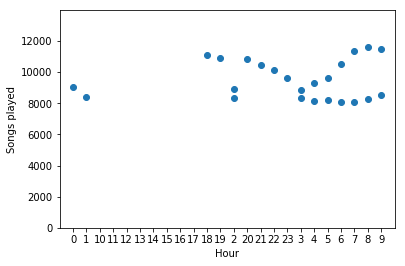

In [17]:
plt.scatter(songs_in_hour_pd["hour"], songs_in_hour_pd["count"])
plt.xlim(-1, 24);
plt.ylim(0, 1.2 * max(songs_in_hour_pd["count"]))
plt.xlabel("Hour")
plt.ylabel("Songs played");

# Feature Engineering
Once you've familiarized yourself with the data, build out the features you find promising to train your model on. To work with the full dataset, you can follow the following steps.
- Write a script to extract the necessary features from the smaller subset of data
- Ensure that your script is scalable, using the best practices discussed in Lesson 3
- Try your script on the full data set, debugging your script if necessary

If you are working in the classroom workspace, you can just extract features based on the small subset of data contained here. Be sure to transfer over this work to the larger dataset when you work on your Spark cluster.

In [20]:
user_df = df.groupBy('userId').agg(F.max('churn')).withColumnRenamed("max(churn)", "churn")
user_df.show()

+------+-----+
|userId|churn|
+------+-----+
|100010|    0|
|200002|    0|
|   125|    1|
|    51|    1|
|   124|    0|
|     7|    0|
|    54|    1|
|    15|    0|
|   155|    0|
|   132|    0|
|   154|    0|
|100014|    1|
|   101|    1|
|    11|    0|
|   138|    0|
|300017|    0|
|    29|    1|
|    69|    0|
|100021|    1|
|    42|    0|
+------+-----+
only showing top 20 rows



Text(0.5,1,'churned')

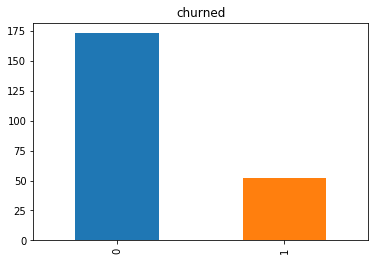

In [21]:
#Target Varaible (Churn) distribution
pd = user_df.select('churn').toPandas()
pd['churn'].value_counts().plot('bar').set_title('churned')


In [22]:
#artist count
artist_count = df.groupBy('userId').agg({'artist':'count'}).withColumnRenamed('count(artist)','artist_count')
user_df=user_df.join(artist_count, ['userId'])
#artist_count.show()

In [23]:
#a = user_df.select('artist_count').toPandas()
#b = user_df.select('churn').toPandas()

col1 = 'artist_count'
col2 = 'churn'
pd = user_df.select(col1,col2).toPandas()
a = pd[col1][pd[col2]==1]
b = pd[col1][pd[col2]==0]
print(stats.ttest_ind(a=a,b=b,equal_var=True))


Ttest_indResult(statistic=-2.3601519780787981, pvalue=0.01913005829224226)


Text(0.5,1,' not churned')

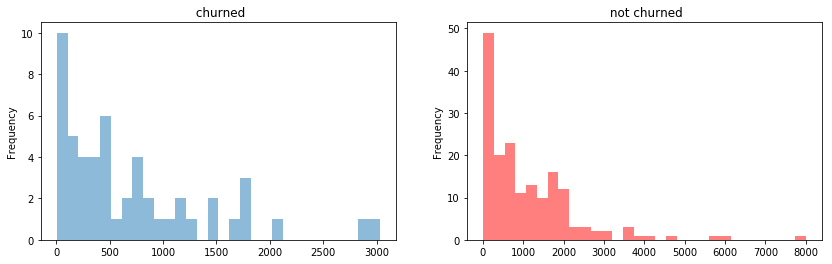

In [24]:
fig, ax = plt.subplots(1, 2, figsize=(14, 4))
col1 = 'artist_count'
col2 = 'churn'
pd = user_df.select(col1,col2).toPandas()
pd[col1][pd[col2]==1].plot('hist', bins =30, alpha =0.5, ax=ax[0]).set_title(' churned')
pd[col1][pd[col2]==0].plot('hist',bins =30,  color ='red', alpha =0.5 ,ax=ax[1]).set_title(' not churned')


In [28]:
# song count 
song_count = df.groupBy('userId').agg({'song':'count'}).withColumnRenamed('count(song)','song_count')
user_df=user_df.join(song_count, ['userId'])
#user_df=user_df.drop('song_count')
#user_df = user_df.drop('song_count')
#song_count.show()

#song count
#a = user_df.select('song_count').toPandas()
#b = user_df.select('churn').toPandas()
pd = user_df.select(col1,col2).toPandas()
col1 = 'song_count'
col2 = 'churn'
a = pd[col1][pd[col2]==1]
b = pd[col1][pd[col2]==0]
print(stats.ttest_ind(a=a,b=b,equal_var=True))



Ttest_indResult(statistic=-2.3601519780787981, pvalue=0.01913005829224226)


Text(0.5,1,' not churned')

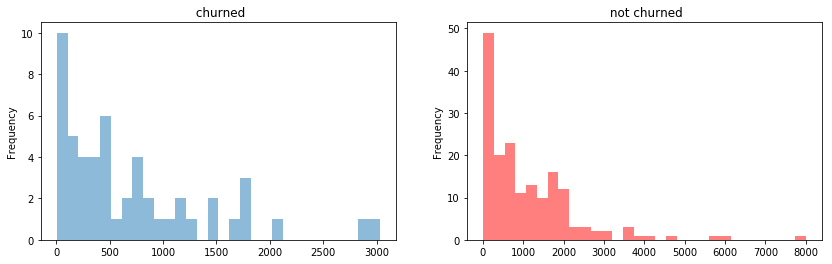

In [29]:
fig, ax = plt.subplots(1, 2, figsize=(14, 4))
col1 = 'song_count'
col2 = 'churn'
pd = user_df.select(col1,col2).toPandas()
pd[col1][pd[col2]==1].plot('hist', bins =30, alpha =0.5, ax=ax[0]).set_title(' churned')
pd[col1][pd[col2]==0].plot('hist',bins =30,  color ='red', alpha =0.5 ,ax=ax[1]).set_title(' not churned')


In [30]:
#user id counts that downgraded
downgrade_count = df.groupBy('userId').agg(F.sum('downgraded')).withColumnRenamed('sum(downgraded)','downgrade_count')
user_df=user_df.join(downgrade_count, ['userId'])
downgrade_count.describe().show()

+-------+------------------+------------------+
|summary|            userId|   downgrade_count|
+-------+------------------+------------------+
|  count|               225|               225|
|   mean|65391.013333333336|              0.28|
| stddev|105396.47791907164|0.5876709477736184|
|    min|                10|                 0|
|    max|                99|                 3|
+-------+------------------+------------------+



In [31]:
# Stats for total registration period of users
df_last_ts = df.select('userId','ts').groupby('userId').agg(F.max('ts'))
#df_last_ts.show()
df_registration_ts = df.select('userId','registration').groupby('userId').agg(F.min('registration'))
#df_registration_ts.show()
df_last_ts = df_last_ts.join(df_registration_ts,['userId'])
df_reg_length = df_last_ts.withColumn('total_reg_days',(col('max(ts)')-col('min(registration)'))/86400000)
#df_reg_length.show()
user_df=user_df.join(df_reg_length.select('userId','total_reg_days'), ['userId'])

In [32]:
col1 = 'total_reg_days'
col2 = 'churn'
pd = user_df.select(col1,col2).toPandas()
a = pd[col1][pd[col2]==1]
b = pd[col1][pd[col2]==0]
print(stats.ttest_ind(a=a,b=b,equal_var=True))


Ttest_indResult(statistic=-5.1999725267949124, pvalue=4.5041425910754789e-07)


Text(0.5,1,' not churned')

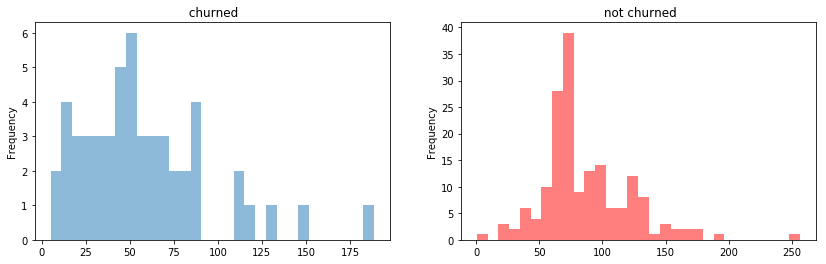

In [33]:
fig, ax = plt.subplots(1, 2, figsize=(14, 4))
col1 = 'total_reg_days'
col2 = 'churn'
pd = user_df.select(col1,col2).toPandas()
pd[col1][pd[col2]==1].plot('hist', bins =30, alpha =0.5, ax=ax[0]).set_title(' churned')
pd[col1][pd[col2]==0].plot('hist',bins =30,  color ='red', alpha =0.5 ,ax=ax[1]).set_title(' not churned')


In [78]:
#Gender
func_gender = udf(lambda x: 1 if x == 'F' else 0, IntegerType())
df = df.withColumn('func_gender',func_gender('gender'))
genderdf = df.groupBy('userId').agg(F.max('func_gender'))
user_df=user_df.join(genderdf, ['userId'])

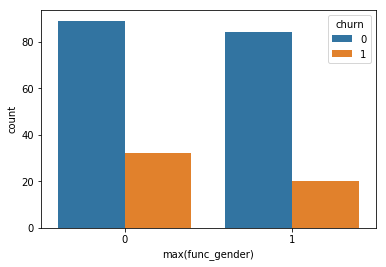

In [79]:
pd = user_df.select('userId','churn','max(func_gender)').toPandas()
sns.countplot(x = 'max(func_gender)',hue = 'churn',data = pd)

In [36]:
# length 
total_length = df.groupBy('userId').agg(F.sum('length')).withColumnRenamed('sum(length)','total_length')
user_df=user_df.join(total_length, ['userId'])

Text(0.5,1,' not churned')

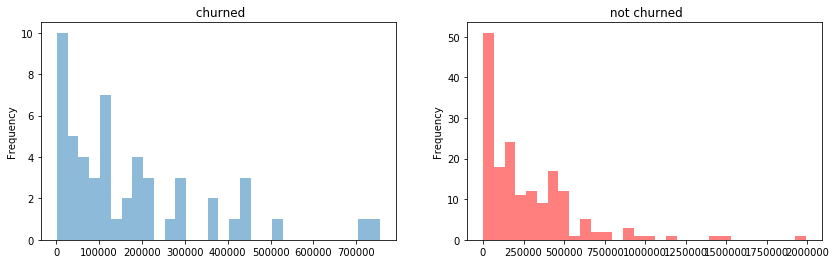

In [37]:
fig, ax = plt.subplots(1, 2, figsize=(14, 4))
col1 = 'total_length'
col2 = 'churn'
pd = user_df.select(col1,col2).toPandas()
pd[col1][pd[col2]==1].plot('hist', bins =30, alpha =0.5, ax=ax[0]).set_title(' churned')
pd[col1][pd[col2]==0].plot('hist',bins =30,  color ='red', alpha =0.5 ,ax=ax[1]).set_title(' not churned')


In [38]:
# sessions
session_count = df.groupBy('userId').agg(count('sessionId')).withColumnRenamed('count(sessionId)','session_count')
user_df=user_df.join(session_count, ['userId'])

Text(0.5,1,' not churned')

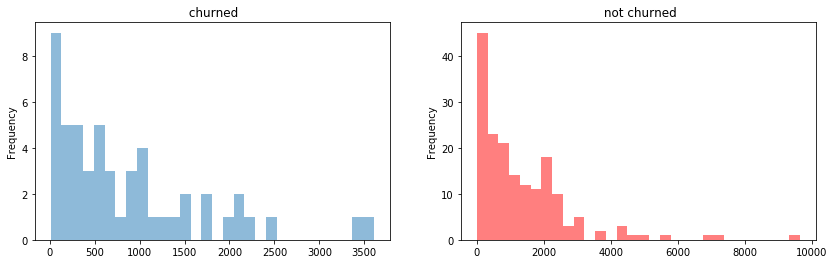

In [39]:
fig, ax = plt.subplots(1, 2, figsize=(14, 4))
col1 = 'session_count'
col2 = 'churn'
pd = user_df.select(col1,col2).toPandas()
pd[col1][pd[col2]==1].plot('hist', bins =30, alpha =0.5, ax=ax[0]).set_title(' churned')
pd[col1][pd[col2]==0].plot('hist',bins =30,  color ='red', alpha =0.5 ,ax=ax[1]).set_title(' not churned')


In [87]:
# level 
func_level = udf(lambda x: 1 if x == 'paid' else 0, IntegerType())
df = df.withColumn('func_level',func_level('level'))
leveldf = df.groupBy('userId').agg(F.max('func_level')).withColumnRenamed('max(func_level)','level')
user_df = user_df.join(leveldf,['userId'])
#user_df = user_df.drop('level')
#user_df = user_df.drop('level')
#user_df = user_df.drop('level')

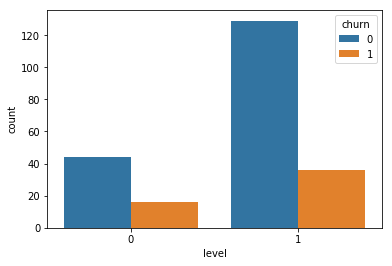

In [88]:
pd = user_df.select('userId','churn','level').toPandas()
sns.countplot(x = 'level',hue = 'churn',data = pd)

In [42]:
#df.select('page').distinct().show()
df_page=df.groupBy('userId').pivot('page').count().na.fill(0).drop('Cancellation Confirmation','Cancel','Error','Login',
                                                                   'Logout','NextSong','Settings',
                                                                  'Submit Downgrade','Submit Upgrade','Submit Registration','Downgrade',
                                                                   'Upgrade','Home','Help','Save Settings','About'
                                                                  )
df_page.show()

+------+----------+---------------+-----------+-----------+---------+
|userId|Add Friend|Add to Playlist|Roll Advert|Thumbs Down|Thumbs Up|
+------+----------+---------------+-----------+-----------+---------+
|200002|         4|              8|          7|          6|       21|
|100010|         4|              7|         52|          5|       17|
|   125|         0|              0|          1|          0|        0|
|    51|        28|             52|          0|         21|      100|
|   124|        74|            118|          4|         41|      171|
|     7|         1|              5|         16|          1|        7|
|    54|        33|             72|         47|         29|      163|
|    15|        31|             59|          1|         14|       81|
|   155|        11|             24|          8|          3|       58|
|   132|        41|             38|          2|         17|       96|
|100014|         6|              7|          2|          3|       17|
|   154|         3| 

In [43]:
thumbsdown_count = df_page.groupBy('userId').agg(F.sum('Thumbs Down')).withColumnRenamed('sum(Thumbs Down)','thumbsdown_count')
#thumbsup_count.show()
user_df=user_df.join(thumbsdown_count, ['userId'])
#a = user_df.select('thumbsdown_count').toPandas()
#b = user_df.select('churn').toPandas()
col2= 'thumbsdown_count'
col1= 'churn'
pd = user_df.select(col1,col2).toPandas()
a = pd[col1][pd[col2]==1]
b = pd[col1][pd[col2]==0]
#print(a)
#print(b)
print(stats.ttest_ind(a=a,b=b,equal_var=True))
#pd = user_df.select('userId','churn','thumbsdown_count').toPandas()
#sns.countplot(x = 'thumbsdown_count',hue = 'churn',data = pd)

Ttest_indResult(statistic=1.3513278493843528, pvalue=0.18382481091003941)


Text(0.5,1,'Thumbs Down not churned')

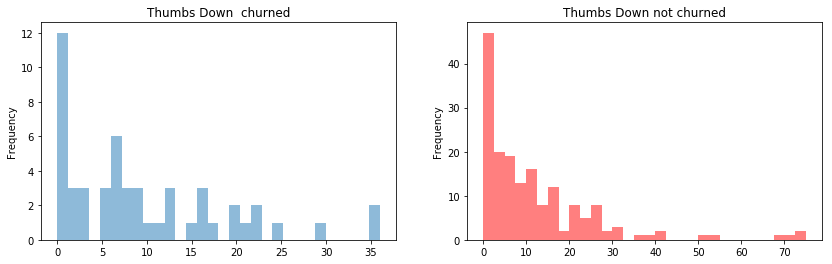

In [44]:
fig, ax = plt.subplots(1, 2, figsize=(14, 4))
col1 = 'thumbsdown_count'
col2 = 'churn'
pd = user_df.select(col1,col2).toPandas()
pd[col1][pd[col2]==1].plot('hist', bins =30, alpha =0.5, ax=ax[0]).set_title('Thumbs Down  churned')
pd[col1][pd[col2]==0].plot('hist',bins =30,  color ='red', alpha =0.5 ,ax=ax[1]).set_title('Thumbs Down not churned')


In [64]:
addtoplaylist_count = df_page.groupBy('userId').agg(F.sum('Add to Playlist')).withColumnRenamed('sum(Add to Playlist)','addtoplaylist_count')

user_df=user_df.join(addtoplaylist_count, ['userId'])
#user_df=user_df.drop('sum(Add to Playlist)')
#user_df=user_df.drop('sum(Add to Playlist)')
#user_df=user_df.drop('sum(Add to Playlist)')
#user_df=user_df.drop('sum(Add to Playlist)')
user_df.printSchema()

root
 |-- userId: string (nullable = true)
 |-- churn: integer (nullable = true)
 |-- artist_count: long (nullable = false)
 |-- song_count: long (nullable = false)
 |-- downgrade_count: long (nullable = true)
 |-- total_reg_days: double (nullable = true)
 |-- max(int_gender): integer (nullable = true)
 |-- total_length: double (nullable = true)
 |-- session_count: long (nullable = false)
 |-- level: integer (nullable = true)
 |-- thumbsdown_count: long (nullable = true)
 |-- addtoplaylist_count: long (nullable = true)



Text(0.5,1,' not churned')

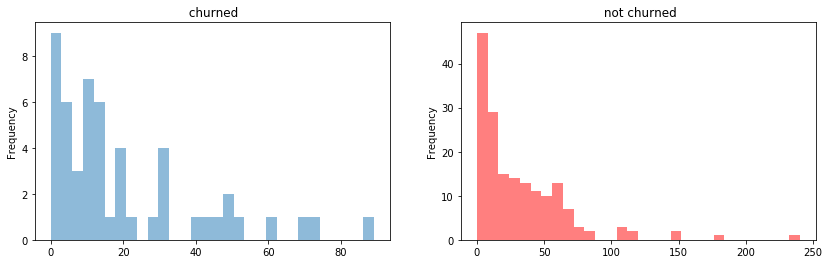

In [65]:
fig, ax = plt.subplots(1, 2, figsize=(14, 4))
col1 = 'addtoplaylist_count'
col2 = 'churn'
pd = user_df.select(col1,col2).toPandas()
pd[col1][pd[col2]==1].plot('hist', bins =30, alpha =0.5, ax=ax[0]).set_title(' churned')
pd[col1][pd[col2]==0].plot('hist',bins =30,  color ='red', alpha =0.5 ,ax=ax[1]).set_title(' not churned')



In [67]:
addfriend_count = df_page.groupBy('userId').agg(F.sum('Add Friend')).withColumnRenamed('sum(Add Friend)','addfriend_count')
#thumbsup_count.show()
user_df=user_df.join(addfriend_count, ['userId'])
col2= 'addfriend_count'
col1= 'churn'
pd = user_df.select(col1,col2).toPandas()
a = pd[col1][pd[col2]==1]
b = pd[col1][pd[col2]==0]
print(stats.ttest_ind(a=a,b=b,equal_var=True))

Ttest_indResult(statistic=-0.81950859734491988, pvalue=0.42024081945361502)


Text(0.5,1,' not churned')

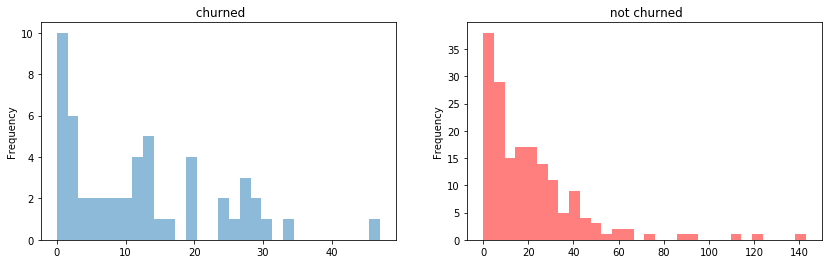

In [68]:
fig, ax = plt.subplots(1, 2, figsize=(14, 4))
col1 = 'addfriend_count'
col2 = 'churn'
pd = user_df.select(col1,col2).toPandas()
pd[col1][pd[col2]==1].plot('hist', bins =30, alpha =0.5, ax=ax[0]).set_title(' churned')
pd[col1][pd[col2]==0].plot('hist',bins =30,  color ='red', alpha =0.5 ,ax=ax[1]).set_title(' not churned')


In [69]:
rolladvert_count = df_page.groupBy('userId').agg(F.sum('Roll Advert')).withColumnRenamed('sum(Roll Advert)','rolladvert_count')
#thumbsup_count.show()
user_df=user_df.join(rolladvert_count, ['userId'])
#user_df=user_df.drop('rolladvert_count')
col2= 'rolladvert_count'
col1= 'churn'
pd = user_df.select(col1,col2).toPandas()
a = pd[col1][pd[col2]==1]
b = pd[col1][pd[col2]==0]
#print(a)
#print(b)
print(stats.ttest_ind(a=a,b=b,equal_var=True))


Ttest_indResult(statistic=0.46987149389936472, pvalue=0.64144667827912882)


Text(0.5,1,' not churned')

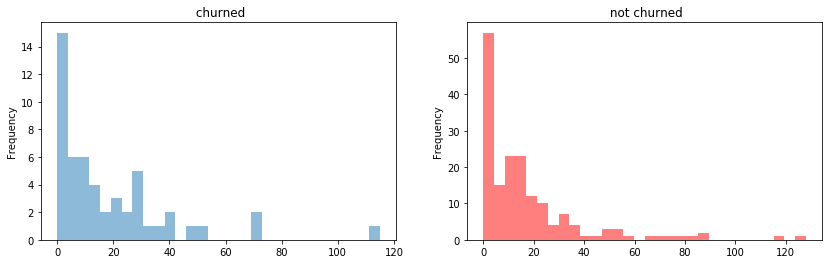

In [82]:
fig, ax = plt.subplots(1, 2, figsize=(14, 4))
col1 = 'rolladvert_count'
col2 = 'churn'
pd = user_df.select(col1,col2).toPandas()
pd[col1][pd[col2]==1].plot('hist', bins =30, alpha =0.5, ax=ax[0]).set_title(' churned')
pd[col1][pd[col2]==0].plot('hist',bins =30,  color ='red', alpha =0.5 ,ax=ax[1]).set_title(' not churned')


In [70]:

thumbsup_count = df_page.groupBy('userId').agg(F.sum('Thumbs Up')).withColumnRenamed('sum(Thumbs Up)','thumbsup_count')
#thumbsup_count.show()
user_df=user_df.join(thumbsup_count, ['userId'])
#user_df=user_df.drop('thumbsup_count')
#a = user_df.select('thumbsup_count').toPandas()
#b = user_df.select('churn').toPandas()
col1= 'thumbsup_count'
col2= 'churn'
pd = user_df.select(col1,col2).toPandas()
a = pd[col1][pd[col2]==1]
b = pd[col1][pd[col2]==0]
print(stats.ttest_ind(a=a,b=b,equal_var=True))


Ttest_indResult(statistic=-2.5465799259653137, pvalue=0.011552536742223812)


Text(0.5,1,' not churned')

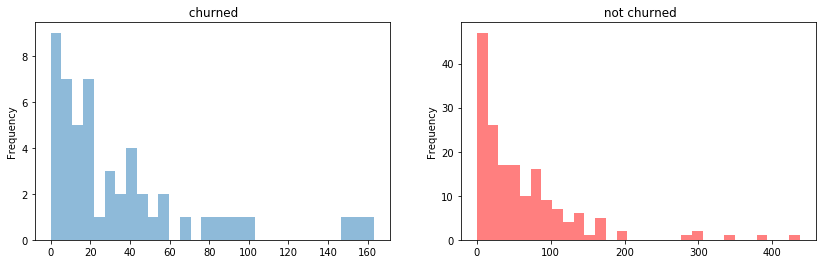

In [71]:
fig, ax = plt.subplots(1, 2, figsize=(14, 4))
col1 = 'thumbsup_count'
col2 = 'churn'
pd = user_df.select(col1,col2).toPandas()
pd[col1][pd[col2]==1].plot('hist', bins =30, alpha =0.5, ax=ax[0]).set_title(' churned')
pd[col1][pd[col2]==0].plot('hist',bins =30,  color ='red', alpha =0.5 ,ax=ax[1]).set_title(' not churned')


In [89]:
#user_df = user_df.drop('max(int_gender)','level: integer')
user_df.printSchema()

root
 |-- userId: string (nullable = true)
 |-- churn: integer (nullable = true)
 |-- artist_count: long (nullable = false)
 |-- song_count: long (nullable = false)
 |-- downgrade_count: long (nullable = true)
 |-- total_reg_days: double (nullable = true)
 |-- total_length: double (nullable = true)
 |-- session_count: long (nullable = false)
 |-- thumbsdown_count: long (nullable = true)
 |-- addtoplaylist_count: long (nullable = true)
 |-- addfriend_count: long (nullable = true)
 |-- rolladvert_count: long (nullable = true)
 |-- thumbsup_count: long (nullable = true)
 |-- max(func_gender): integer (nullable = true)
 |-- level: integer (nullable = true)



# Modeling
Split the full dataset into train, test, and validation sets. Test out several of the machine learning methods you learned. Evaluate the accuracy of the various models, tuning parameters as necessary. Determine your winning model based on test accuracy and report results on the validation set. Since the churned users are a fairly small subset, I suggest using F1 score as the metric to optimize.

In [96]:
cols = user_df.columns
features = [col for col in user_df.columns if col!='churn'] 
print(features)
stages = []
#user_df = user_df.withColumn("userID", user_df["userID"].cast(IntegerType()))

['userID', 'artist_count', 'song_count', 'downgrade_count', 'total_reg_days', 'total_length', 'session_count', 'thumbsdown_count', 'addtoplaylist_count', 'addfriend_count', 'rolladvert_count', 'thumbsup_count', 'max(func_gender)', 'level']


In [97]:
from pyspark.ml import Pipeline
from pyspark.ml.feature import StringIndexer, VectorAssembler

In [98]:
user_df = user_df.withColumn("churn", user_df["churn"].cast(StringType()))


In [99]:
label_Indx = StringIndexer(inputCol = 'churn', outputCol = 'label')
stages += [label_Indx]

In [100]:
assembler = VectorAssembler(inputCols=features, outputCol="features")
stages += [assembler]
scaler = MinMaxScaler(inputCol="features", outputCol="scaled_features")
stages += [scaler]
pipeline = Pipeline(stages=stages)

In [101]:
pipelineModel = pipeline.fit(user_df)

In [102]:
user_df = pipelineModel.transform(user_df)

In [103]:

selectedCols = ['label', 'features'] + cols

In [104]:
user_df = user_df.select(selectedCols)

In [105]:
user_df.printSchema()

root
 |-- label: double (nullable = false)
 |-- features: vector (nullable = true)
 |-- userID: integer (nullable = true)
 |-- churn: string (nullable = true)
 |-- artist_count: long (nullable = false)
 |-- song_count: long (nullable = false)
 |-- downgrade_count: long (nullable = true)
 |-- total_reg_days: double (nullable = true)
 |-- total_length: double (nullable = true)
 |-- session_count: long (nullable = false)
 |-- thumbsdown_count: long (nullable = true)
 |-- addtoplaylist_count: long (nullable = true)
 |-- addfriend_count: long (nullable = true)
 |-- rolladvert_count: long (nullable = true)
 |-- thumbsup_count: long (nullable = true)
 |-- max(func_gender): integer (nullable = true)
 |-- level: integer (nullable = true)



In [107]:
#pd.DataFrame(user_df.take(5), columns=user_df.columns).transpose()

In [108]:
train, test = user_df.randomSplit([0.7, 0.3], seed=42)
print("Training Dataset Count: " + str(train.count()))
print("Test Dataset Count: " + str(test.count()))

Training Dataset Count: 163
Test Dataset Count: 62


In [109]:
lr = LogisticRegression(featuresCol = 'features', labelCol = 'label', maxIter=10)


In [110]:
lrModel = lr.fit(train)

In [111]:
trainingSummary = lrModel.summary

In [112]:
pr = trainingSummary.pr.toPandas()
plt.plot(pr['recall'],pr['precision'])
plt.ylabel('Precision')
plt.xlabel('Recall')
plt.show()

In [113]:
predictions = lrModel.transform(test)
predictions.select('rawPrediction', 'prediction', 'probability').show(10)

+--------------------+----------+--------------------+
|       rawPrediction|prediction|         probability|
+--------------------+----------+--------------------+
|[0.29917172555729...|       0.0|[0.57424002576599...|
|[5.13595486836847...|       0.0|[0.99415295616663...|
|[1.25980607633861...|       0.0|[0.77899272309509...|
|[2.60472860784138...|       0.0|[0.93116528548609...|
|[1.00561944730204...|       0.0|[0.73216199342665...|
|[4.70951101873260...|       0.0|[0.99107125882601...|
|[1.61310914168182...|       0.0|[0.83384260249779...|
|[2.43583708883203...|       0.0|[0.91951955601244...|
|[2.11880372712691...|       0.0|[0.89271741264451...|
|[0.85200852214470...|       0.0|[0.70098830602642...|
+--------------------+----------+--------------------+
only showing top 10 rows



In [118]:
results = predictions.select(['prediction', 'label'])
predictionAndLabels=results.rdd
metrics = MulticlassMetrics(predictionAndLabels)

In [120]:
cm=metrics.confusionMatrix().toArray()
accuracy=(cm[0][0]+cm[1][1])/cm.sum()
precision=(cm[0][0])/(cm[0][0]+cm[1][0])
recall=(cm[0][0])/(cm[0][0]+cm[0][1])
print("Logistic RegressionClassifier: accuracy,precision,recall",accuracy,precision,recall)


Logistic RegressionClassifier: accuracy,precision,recall 0.790322580645 0.803571428571 0.957446808511


In [121]:
#Using Random Forest Classifier
rf = RandomForestClassifier(labelCol='label', featuresCol='features')

In [122]:
rfModel = rf.fit(train)

In [123]:
predictionsrf = rfModel.transform(test)

In [124]:
resultsrf = predictionsrf.select(['prediction', 'label'])
predictionAndLabelsrf=resultsrf.rdd
metricsrf = MulticlassMetrics(predictionAndLabelsrf)

In [125]:
cm=metricsrf.confusionMatrix().toArray()
accuracy=(cm[0][0]+cm[1][1])/cm.sum()
precision=(cm[0][0])/(cm[0][0]+cm[1][0])
recall=(cm[0][0])/(cm[0][0]+cm[0][1])
print("Random Forest Classifier: accuracy,precision,recall",accuracy,precision,recall)

Random Forest Classifier: accuracy,precision,recall 0.838709677419 0.836363636364 0.978723404255


# Final Steps
Clean up your code, adding comments and renaming variables to make the code easier to read and maintain. Refer to the Spark Project Overview page and Data Scientist Capstone Project Rubric to make sure you are including all components of the capstone project and meet all expectations. Remember, this includes thorough documentation in a README file in a Github repository, as well as a web app or blog post.